c:\Users\ARA\Desktop\Outfit-Aura\OUTFIT-AURA-web-application-\outfit\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\ARA\Desktop\Outfit-Aura\OUTFIT-AURA-web-application-\outfit\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unique labels in the segmentation map: [ 0  2  4  6 11 14 15]


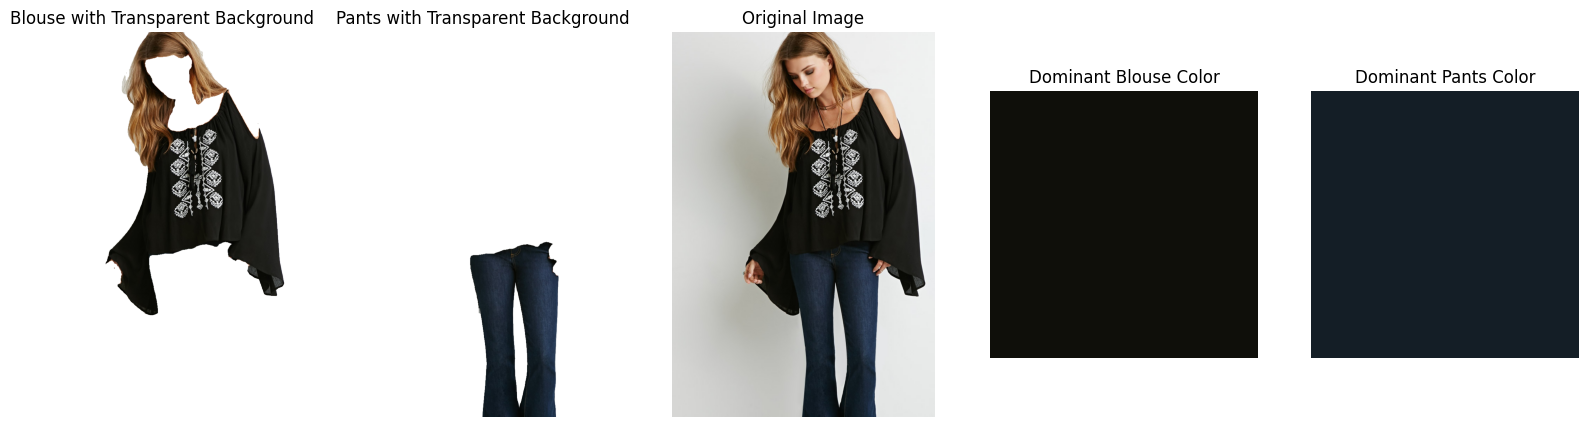

In [94]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.cluster import KMeans

# Load the pre-trained segmentation model and feature extractor
model_name = "mattmdjaga/segformer_b2_clothes"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

def segment_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the segmentation map
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    segmentation = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    
    return segmentation, image

def create_transparent_image(image, mask):
    # Convert image to RGBA
    image_np = np.array(image)
    image_rgba = Image.fromarray(image_np).convert("RGBA")

    # Set alpha channel to 0 for background
    alpha_channel = np.where(mask == 0, 0, 255).astype(np.uint8)
    image_rgba.putalpha(Image.fromarray(alpha_channel))

    return image_rgba

def extract_dominant_color(image, mask, num_clusters=5):
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Convert image to RGB format
    masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_RGBA2RGB)

    # Reshape the image to be a list of pixels
    pixels = masked_image_rgb.reshape((-1, 3))

    # Remove black pixels (background)
    pixels = pixels[np.any(pixels != [0, 0, 0], axis=-1)]

    # Remove outliers by excluding small regions
    if len(pixels) == 0:
        print("No pixels found for the given mask.")
        return np.array([0, 0, 0])  # Return black as a fallback

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(pixels)

    # Find the largest cluster and its center
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    dominant_color = kmeans.cluster_centers_[np.argmax(counts)]

    return dominant_color

def display_results(image, blouse_image, pants_image, blouse_color, pants_color):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 5, 1)
    plt.imshow(blouse_image)
    plt.title("Blouse with Transparent Background")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(pants_image)
    plt.title("Pants with Transparent Background")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow([[blouse_color / 255]])
    plt.title("Dominant Blouse Color")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow([[pants_color / 255]])
    plt.title("Dominant Pants Color")
    plt.axis('off')

    plt.show()

# Path to your uploaded image
image_path = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/images/WOMEN-Blouses_Shirts-id_00000004-03_1_front.jpg"
segmentation, image = segment_image(image_path)

# Print unique labels in the segmentation map for debugging
unique_labels = np.unique(segmentation)
print("Unique labels in the segmentation map:", unique_labels)

# Define the labels for blouse and pants
blouse_labels = [1, 2, 3, 4]  # Adjust these labels as necessary
pants_labels = [5, 6, 7, 8, 9, 10] # Adjust these labels as necessary

# Create the mask and transparent image for the blouse
blouse_mask = np.isin(segmentation, blouse_labels).astype(np.uint8) * 255
blouse_image = create_transparent_image(image, blouse_mask)

# Create the mask and transparent image for the pants
pants_mask = np.isin(segmentation, pants_labels).astype(np.uint8) * 255
pants_image = create_transparent_image(image, pants_mask)

# Extract dominant colors with increased number of clusters and filtering
blouse_color = extract_dominant_color(np.array(blouse_image), blouse_mask, num_clusters=5)
pants_color = extract_dominant_color(np.array(pants_image), pants_mask, num_clusters=5)

# Display the results
display_results(image, blouse_image, pants_image, blouse_color, pants_color)


In [20]:
import os
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import numpy as np
from PIL import Image
from tqdm import tqdm

# Load the pre-trained segmentation model and feature extractor
model_name = "mattmdjaga/segformer_b2_clothes"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def segment_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=[image], return_tensors="pt").to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the segmentation map
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    segmentation = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    
    return segmentation, image

def create_transparent_image(image, mask):
    # Convert image to RGBA
    image_np = np.array(image)
    image_rgba = Image.fromarray(image_np).convert("RGBA")

    # Set alpha channel to 0 for background
    alpha_channel = np.where(mask == 0, 0, 255).astype(np.uint8)
    image_rgba.putalpha(Image.fromarray(alpha_channel))

    return image_rgba

def process_folder(input_folder, output_folder, labels, image_size=(256, 256)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    filenames = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for filename in tqdm(filenames):
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path).convert("RGB").resize(image_size)
        segmentation, image = segment_image(image_path)

        # Create the mask and transparent image for the given labels
        mask = np.isin(segmentation, labels).astype(np.uint8) * 255
        segmented_image = create_transparent_image(image, mask)
        
        # Save the segmented image
        segmented_image.save(os.path.join(output_folder, filename.replace('.jpg', '.png').replace('.jpeg', '.png')))

# Path to your folders
input_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/upper_body/female"
output_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/female_upper"
labels = [3, 4]  # Adjust these labels as necessary

process_folder(input_folder, output_folder, labels)


c:\Users\ARA\Desktop\Outfit-Aura\OUTFIT-AURA-web-application-\outfit\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\ARA\Desktop\Outfit-Aura\OUTFIT-AURA-web-application-\outfit\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
100%|██████████| 4051/4051 [1:48:23<00:00,  1.61s/it]  


In [21]:
import os
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import numpy as np
from PIL import Image
from tqdm import tqdm

# Load the pre-trained segmentation model and feature extractor
model_name = "mattmdjaga/segformer_b2_clothes"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def segment_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=[image], return_tensors="pt").to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the segmentation map
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    segmentation = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    
    return segmentation, image

def create_transparent_image(image, mask):
    # Convert image to RGBA
    image_np = np.array(image)
    image_rgba = Image.fromarray(image_np).convert("RGBA")

    # Set alpha channel to 0 for background
    alpha_channel = np.where(mask == 0, 0, 255).astype(np.uint8)
    image_rgba.putalpha(Image.fromarray(alpha_channel))

    return image_rgba

def process_folder(input_folder, output_folder, labels, image_size=(256, 256)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    filenames = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for filename in tqdm(filenames):
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path).convert("RGB").resize(image_size)
        segmentation, image = segment_image(image_path)

        # Create the mask and transparent image for the given labels
        mask = np.isin(segmentation, labels).astype(np.uint8) * 255
        segmented_image = create_transparent_image(image, mask)
        
        # Save the segmented image
        segmented_image.save(os.path.join(output_folder, filename.replace('.jpg', '.png').replace('.jpeg', '.png')))

# Path to your folders
input_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/lower_body/female"
output_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/female_lowers"
labels = [5, 6, 7, 8, 9, 10]  # Adjust these labels as necessary

process_folder(input_folder, output_folder, labels)


100%|██████████| 1501/1501 [37:41<00:00,  1.51s/it]


In [22]:
import os
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import numpy as np
from PIL import Image
from tqdm import tqdm

# Load the pre-trained segmentation model and feature extractor
model_name = "mattmdjaga/segformer_b2_clothes"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def segment_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=[image], return_tensors="pt").to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the segmentation map
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    segmentation = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    
    return segmentation, image

def create_transparent_image(image, mask):
    # Convert image to RGBA
    image_np = np.array(image)
    image_rgba = Image.fromarray(image_np).convert("RGBA")

    # Set alpha channel to 0 for background
    alpha_channel = np.where(mask == 0, 0, 255).astype(np.uint8)
    image_rgba.putalpha(Image.fromarray(alpha_channel))

    return image_rgba

def process_folder(input_folder, output_folder, labels, image_size=(256, 256)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    filenames = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for filename in tqdm(filenames):
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path).convert("RGB").resize(image_size)
        segmentation, image = segment_image(image_path)

        # Create the mask and transparent image for the given labels
        mask = np.isin(segmentation, labels).astype(np.uint8) * 255
        segmented_image = create_transparent_image(image, mask)
        
        # Save the segmented image
        segmented_image.save(os.path.join(output_folder, filename.replace('.jpg', '.png').replace('.jpeg', '.png')))

# Path to your folders
input_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/lower_body/male"
output_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/male_lowers"
labels = [5, 6, 7, 8, 9, 10]  # Adjust these labels as necessary

process_folder(input_folder, output_folder, labels)


100%|██████████| 243/243 [05:49<00:00,  1.44s/it]


In [23]:
import os
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import numpy as np
from PIL import Image
from tqdm import tqdm

# Load the pre-trained segmentation model and feature extractor
model_name = "mattmdjaga/segformer_b2_clothes"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# Check if a GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def segment_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=[image], return_tensors="pt").to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the segmentation map
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    segmentation = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    
    return segmentation, image

def create_transparent_image(image, mask):
    # Convert image to RGBA
    image_np = np.array(image)
    image_rgba = Image.fromarray(image_np).convert("RGBA")

    # Set alpha channel to 0 for background
    alpha_channel = np.where(mask == 0, 0, 255).astype(np.uint8)
    image_rgba.putalpha(Image.fromarray(alpha_channel))

    return image_rgba

def process_folder(input_folder, output_folder, labels, image_size=(256, 256)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    filenames = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for filename in tqdm(filenames):
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path).convert("RGB").resize(image_size)
        segmentation, image = segment_image(image_path)

        # Create the mask and transparent image for the given labels
        mask = np.isin(segmentation, labels).astype(np.uint8) * 255
        segmented_image = create_transparent_image(image, mask)
        
        # Save the segmented image
        segmented_image.save(os.path.join(output_folder, filename.replace('.jpg', '.png').replace('.jpeg', '.png')))

# Path to your folders
input_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/upper_body/male"
output_folder = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/male_upper"
labels = [3, 4] # Adjust these labels as necessary

process_folder(input_folder, output_folder, labels)


100%|██████████| 191/191 [04:51<00:00,  1.53s/it]


c:\Users\ARA\Desktop\Outfit-Aura\OUTFIT-AURA-web-application-\outfit\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\ARA\Desktop\Outfit-Aura\OUTFIT-AURA-web-application-\outfit\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Unique labels in the segmentation map: [ 0  2  4  6 11 14 15]


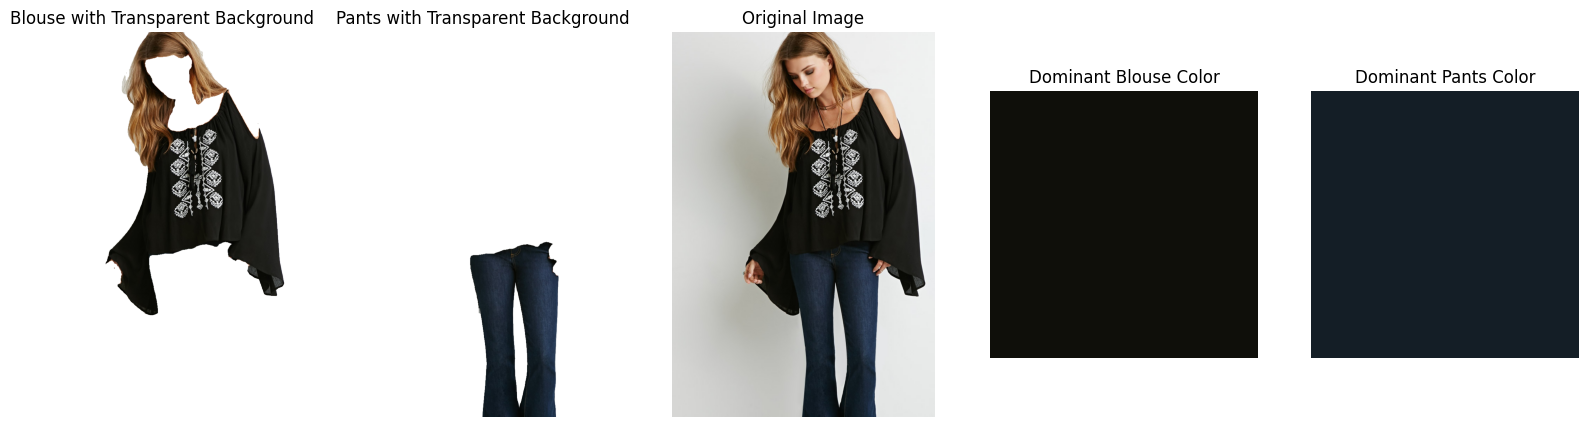

In [14]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.cluster import KMeans

# Load the pre-trained segmentation model and feature extractor
model_name = "mattmdjaga/segformer_b2_clothes"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

def segment_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the segmentation map
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    segmentation = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    
    return segmentation, image

def create_transparent_image(image, mask):
    # Convert image to RGBA
    image_np = np.array(image)
    image_rgba = Image.fromarray(image_np).convert("RGBA")

    # Set alpha channel to 0 for background
    alpha_channel = np.where(mask == 0, 0, 255).astype(np.uint8)
    image_rgba.putalpha(Image.fromarray(alpha_channel))

    return image_rgba

def extract_dominant_color(image, mask, num_clusters=5):
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Convert image to RGB format
    masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_RGBA2RGB)

    # Reshape the image to be a list of pixels
    pixels = masked_image_rgb.reshape((-1, 3))

    # Remove black pixels (background)
    pixels = pixels[np.any(pixels != [0, 0, 0], axis=-1)]

    # Remove outliers by excluding small regions
    if len(pixels) == 0:
        print("No pixels found for the given mask.")
        return np.array([0, 0, 0])  # Return black as a fallback

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(pixels)

    # Find the largest cluster and its center
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    dominant_color = kmeans.cluster_centers_[np.argmax(counts)]

    return dominant_color

def classify_color(color):
    """
    Classify the given RGB color to a predefined color category.
    """
    # Define basic colors and their RGB values
    colors = {
        "red": [255, 0, 0],
        "green": [0, 255, 0],
        "blue": [0, 0, 255],
        "yellow": [255, 255, 0],
        "cyan": [0, 255, 255],
        "magenta": [255, 0, 255],
        "black": [0, 0, 0],
        "white": [255, 255, 255],
        "grey": [128, 128, 128]
    }

    # Calculate the distance between the given color and each basic color
    distances = {k: np.linalg.norm(np.array(v) - np.array(color[:3])) for k, v in colors.items()}
    
    # Return the closest color
    return min(distances, key=distances.get)

def display_results(image, blouse_image, pants_image, blouse_color, pants_color):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 5, 1)
    plt.imshow(blouse_image)
    plt.title("Blouse with Transparent Background")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(pants_image)
    plt.title("Pants with Transparent Background")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow([[blouse_color / 255]])
    plt.title("Dominant Blouse Color")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow([[pants_color / 255]])
    plt.title("Dominant Pants Color")
    plt.axis('off')

    plt.show()

# Path to your uploaded image
image_path = "C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data/images/WOMEN-Blouses_Shirts-id_00000004-03_1_front.jpg"
segmentation, image = segment_image(image_path)

# Print unique labels in the segmentation map for debugging
unique_labels = np.unique(segmentation)
print("Unique labels in the segmentation map:", unique_labels)

# Define the labels for blouse and pants
blouse_labels = [1, 2, 3, 4]  # Adjust these labels as necessary
pants_labels = [5, 6, 7, 8, 9, 10] # Adjust these labels as necessary

# Create the mask and transparent image for the blouse
blouse_mask = np.isin(segmentation, blouse_labels).astype(np.uint8) * 255
blouse_image = create_transparent_image(image, blouse_mask)

# Create the mask and transparent image for the pants
pants_mask = np.isin(segmentation, pants_labels).astype(np.uint8) * 255
pants_image = create_transparent_image(image, pants_mask)

# Extract dominant colors with increased number of clusters and filtering
blouse_color = extract_dominant_color(np.array(blouse_image), blouse_mask, num_clusters=5)
pants_color = extract_dominant_color(np.array(pants_image), pants_mask, num_clusters=5)

# Display the results
display_results(image, blouse_image, pants_image, blouse_color, pants_color)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load a model
model_path = 'path_to_your_model.hdf5'
model = load_model(model_path)

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize as per model requirements
    image = image / 255.0  # Normalize if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict color
def predict_color(model, image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    return prediction

# Example usage
image_path = 'path_to_segmented_image.jpg'
prediction = predict_color(model, image_path)
print("Color Prediction:", prediction)
